In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
if ".." not in sys.path: sys.path.append("..")
from common import cosmology

In [2]:
def rhs(log_t, y, Gamma_phi):
    rho_phi, rho_tot, R = np.exp(y)
    t = np.exp(log_t)
    rho_rad = rho_tot - rho_phi
    T = cosmology.calc_temperature(rho_rad)
    H = cosmology.calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    return (d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, d_log_R_d_log_t)

In [8]:
def solve(H_inf, Gamma_phi):
    R0 = 1.0
    rho_phi_inf = cosmology.calc_energy_density_from_hubble(H_inf)
    t_start = 1 / H_inf
    start = np.log(t_start)
    #T_RH = cosmology.calc_reheating_temperature(Gamma_phi)
    t_end = 1 / Gamma_phi * 10 # T_RH**(-2)
    end = np.log(t_end)
    #steps = np.linspace(start, end, 50); steps[0] = start; steps[-1] = end
    sol = solve_ivp(rhs, (start, end), (np.log(rho_phi_inf), np.log(rho_phi_inf), np.log(R0)),
                   args=(Gamma_phi,), dense_output=True, rtol=1e-6)
    
    def T_fn(t):
        y = sol.sol(np.log(t))
        rho_phi, rho_tot, _ = np.exp(y)
        rho_rad = rho_tot - rho_phi
        T = cosmology.calc_temperature(rho_rad)
        return T
    
    def rho_rad_fn(t):
        rho_phi, rho_tot, _ = np.exp(sol.sol(np.log(t)))
        return rho_tot - rho_phi
    
    def rho_phi_fn(t):
        rho_phi, rho_tot, _ = np.exp(sol.sol(np.log(t)))
        return rho_phi
    
    return (t_start, t_end), T_fn, rho_rad_fn, rho_phi_fn

In [22]:
Gamma_phi = 1e8
(t_start, t_end), T_fn, rho_rad_fn, rho_phi_fn = solve(1e12, Gamma_phi)

In [10]:
ts = np.geomspace(t_start, t_end, 400)

Text(0, 0.5, '$\\rho_R$ / GeV^4')

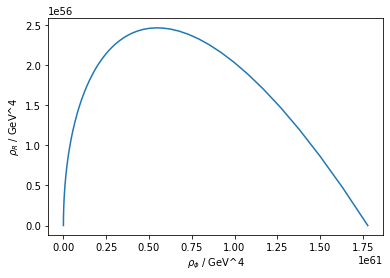

In [15]:
plt.plot(rho_phi_fn(ts), rho_rad_fn(ts))
plt.xlabel(r"$\rho_\phi$ / GeV^4")
plt.ylabel(r"$\rho_R$ / GeV^4")

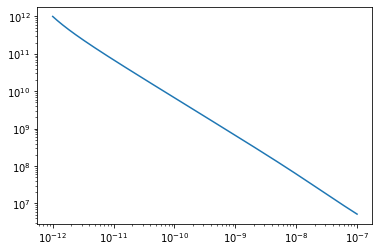

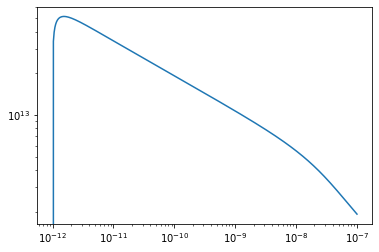

In [17]:
plt.loglog(ts, cosmology.calc_hubble_parameter(rho_phi_fn(ts) + rho_rad_fn(ts)))
plt.show()
plt.loglog(ts, T_fn(ts))

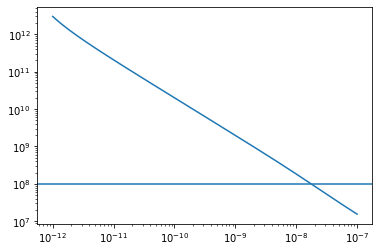

In [25]:
plt.loglog(ts, 3 * cosmology.calc_hubble_parameter(rho_phi_fn(ts) + rho_rad_fn(ts)))
plt.axhline(Gamma_phi)

<ipython-input-26-1dc7f5f1e21b>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(ts, rho_phi_fn(ts) / rho_rad_fn(ts))


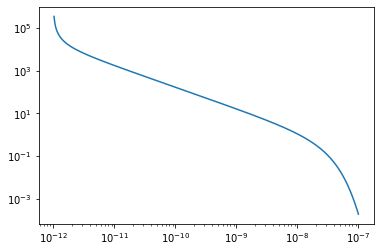

In [26]:
plt.loglog(ts, rho_phi_fn(ts) / rho_rad_fn(ts))

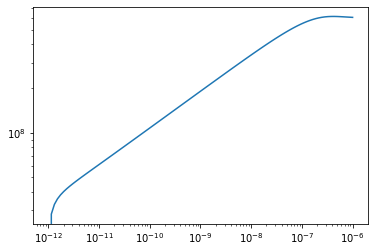

In [4]:
interval, T_fn = solve(1e12, 1e7)
ts = np.geomspace(*interval, 100)
plt.loglog(ts, T_fn(ts) / ts**(-0.5))